In [1]:
import numpy as np
import pandas as pd

# Load base dataset
df = pd.read_csv("base_dataset_2023_2025.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

# 1) Temporal features (cyclical)
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek  # Mon=0
df["dayofyear"] = df["datetime"].dt.dayofyear

# Cyclical encodings
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

# 365.25 handles leap year smoothly
df["doy_sin"] = np.sin(2*np.pi*df["dayofyear"]/365.25)
df["doy_cos"] = np.cos(2*np.pi*df["dayofyear"]/365.25)

df["dow_sin"] = np.sin(2*np.pi*df["dayofweek"]/7)
df["dow_cos"] = np.cos(2*np.pi*df["dayofweek"]/7)

print("Added temporal columns:")
print([c for c in df.columns if c in ["year","month","day","hour","dayofweek","dayofyear",
                                     "hour_sin","hour_cos","doy_sin","doy_cos","dow_sin","dow_cos"]])
df.head()


Added temporal columns:
['year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'hour_sin', 'hour_cos', 'doy_sin', 'doy_cos', 'dow_sin', 'dow_cos']


,city_id,city_name,lat,lon,datetime,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,...,day,hour,dayofweek,dayofyear,hour_sin,hour_cos,doy_sin,doy_cos,dow_sin,dow_cos
0,7701354,Azimpur,23.7298,90.3854,2023-01-01 00:00:00,220.7,154.1,1190.0,87.2,38.2,...,1,0,6,1,0.000000,1.000000,0.017202,0.999852,-0.781831,0.62349
1,7701354,Azimpur,23.7298,90.3854,2023-01-01 01:00:00,213.7,149.0,1227.0,84.9,35.5,...,1,1,6,1,0.258819,0.965926,0.017202,0.999852,-0.781831,0.62349
2,7701354,Azimpur,23.7298,90.3854,2023-01-01 02:00:00,205.4,143.4,1276.0,81.6,31.9,...,1,2,6,1,0.500000,0.866025,0.017202,0.999852,-0.781831,0.62349
3,7701354,Azimpur,23.7298,90.3854,2023-01-01 03:00:00,201.6,140.6,1259.0,73.7,29.6,...,1,3,6,1,0.707107,0.707107,0.017202,0.999852,-0.781831,0.62349
4,7701354,Azimpur,23.7298,90.3854,2023-01-01 04:00:00,193.2,134.6,1111.0,63.0,33.0,...,1,4,6,1,0.866025,0.500000,0.017202,0.999852,-0.781831,0.62349


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler


target = "pm2_5"

# Candidate features (exclude non-numeric IDs and raw datetime)
candidate_features = [
    "pm10",
    "carbon_monoxide",
    "nitrogen_dioxide",
    "sulphur_dioxide",
    "ozone",
    # temporal
    "hour", "hour_sin", "hour_cos",
    "dayofweek", "dow_sin", "dow_cos",
    "dayofyear", "doy_sin", "doy_cos",
    "month"
]

# Ensure they exist
candidate_features = [c for c in candidate_features if c in df.columns]

X = df[candidate_features].copy()
y = df[target].values

# MI works best with scaled continuous inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# Mutual Information (nonlinear dependency)
mi = mutual_info_regression(X_scaled, y, random_state=42)
mi_s = pd.Series(mi, index=candidate_features).sort_values(ascending=False)

# Pearson correlation (linear dependency)
pearson_s = df[candidate_features + [target]].corr(method="pearson")[target].drop(target).abs().sort_values(ascending=False)

# Combine
imp = pd.DataFrame({
    "MI": mi_s,
    "Pearson_abs": pearson_s
}).sort_values(["MI", "Pearson_abs"], ascending=False)

print("\nTop 20 features by Mutual Information (MI):")
print(imp.head(20).to_string())


Top 20 features by Mutual Information (MI):
                        MI  Pearson_abs
pm10              2.251427     0.953909
carbon_monoxide   0.716993     0.797802
dayofyear         0.480488     0.279428
doy_cos           0.469827     0.556804
doy_sin           0.449301     0.245713
sulphur_dioxide   0.379853     0.562295
month             0.305454     0.282404
nitrogen_dioxide  0.222427     0.519562
ozone             0.129135     0.062030
hour              0.040651     0.099047
hour_sin          0.023796     0.177924
hour_cos          0.010781     0.029730
dow_sin           0.003439     0.008543
dayofweek         0.002929     0.008306
dow_cos           0.000641     0.019676


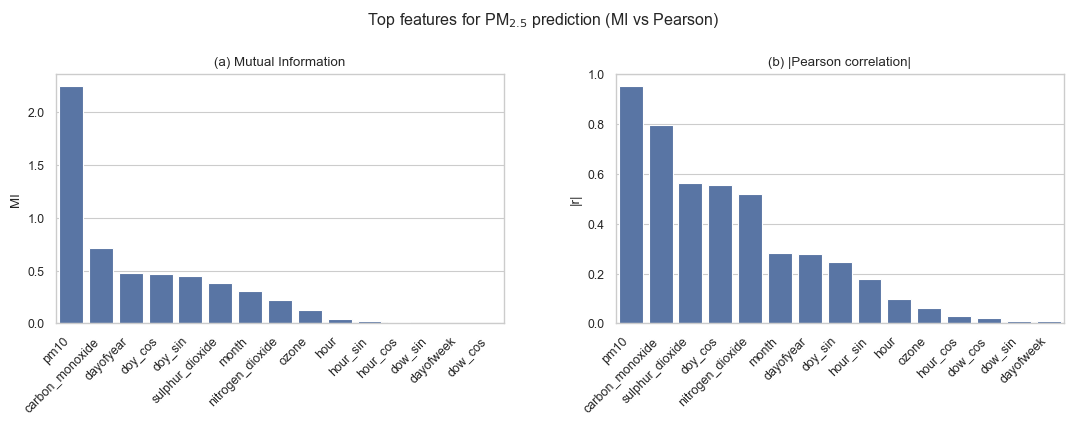

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", context="paper")

topN = 15

imp_mi = imp.sort_values("MI", ascending=False).head(topN).reset_index().rename(columns={"index": "feature"})
imp_p  = imp.sort_values("Pearson_abs", ascending=False).head(topN).reset_index().rename(columns={"index": "feature"})

order_mi = imp_mi["feature"].tolist()
order_p  = imp_p["feature"].tolist()

fig, axes = plt.subplots(1, 2, figsize=(13, 4.3), sharey=False)

# --- (a) MI ---
sns.barplot(data=imp_mi, x="feature", y="MI", ax=axes[0], order=order_mi)
axes[0].set_title("(a) Mutual Information")
axes[0].set_xlabel("")
axes[0].set_ylabel("MI")
axes[0].tick_params(axis="x", rotation=45, labelsize=9)
for lab in axes[0].get_xticklabels():
    lab.set_ha("right")

# --- (b) Pearson ---
sns.barplot(data=imp_p, x="feature", y="Pearson_abs", ax=axes[1], order=order_p)
axes[1].set_title("(b) |Pearson correlation|")
axes[1].set_xlabel("")
axes[1].set_ylabel("|r|")
axes[1].tick_params(axis="x", rotation=45, labelsize=9)
for lab in axes[1].get_xticklabels():
    lab.set_ha("right")

plt.suptitle("Top features for PM$_{2.5}$ prediction (MI vs Pearson)", y=1.03)

# give extra space for rotated labels (this is the key)
plt.subplots_adjust(bottom=0.30, wspace=0.25)

# plt.savefig("Fig_feature_importance_MI_vs_Pearson_top15.png", dpi=300, bbox_inches="tight")
# plt.savefig("Fig_feature_importance_MI_vs_Pearson_top15.pdf", bbox_inches="tight")
plt.savefig("Fig_feature_importance_MI_vs_Pearson_top15.tiff", dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

In [7]:
plt.savefig("Fig_feature_importance_MI_vs_Pearson_top15.tiff", 
            dpi=600, 
            bbox_inches="tight", 
            facecolor="white",
            pil_kwargs={"compression": "tiff_lzw"})

<Figure size 640x480 with 0 Axes>

In [4]:
ID_COLS = ["city_id", "city_name", "lat", "lon", "datetime"]
TARGET = "pm2_5"

FEATURES = [
    "pm10",
    "carbon_monoxide",
    "nitrogen_dioxide",
    "sulphur_dioxide",
    "ozone",
    "doy_sin", "doy_cos",
    "hour_sin", "hour_cos",
]

dataset = df[ID_COLS + FEATURES + [TARGET]].copy()

# Sanity check
assert dataset.isna().sum().sum() == 0, "Unexpected missing values found."
print("Saved dataset columns:", dataset.columns.tolist())
print("Rows:", len(dataset), "| Cities:", dataset["city_name"].nunique(),
      "| Time:", dataset["datetime"].min(), "→", dataset["datetime"].max())


out_path = "dataset_2023_2025.csv"
dataset.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

dataset.head()

Saved dataset columns: ['city_id', 'city_name', 'lat', 'lon', 'datetime', 'pm10', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'doy_sin', 'doy_cos', 'hour_sin', 'hour_cos', 'pm2_5']
Rows: 736368 | Cities: 29 | Time: 2023-01-01 00:00:00 → 2025-11-23 23:00:00
Saved: dataset_2023_2025.csv


,city_id,city_name,lat,lon,datetime,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,doy_sin,doy_cos,hour_sin,hour_cos,pm2_5
0,7701354,Azimpur,23.7298,90.3854,2023-01-01 00:00:00,220.7,1190.0,87.2,38.2,3.0,0.017202,0.999852,0.000000,1.000000,154.1
1,7701354,Azimpur,23.7298,90.3854,2023-01-01 01:00:00,213.7,1227.0,84.9,35.5,4.0,0.017202,0.999852,0.258819,0.965926,149.0
2,7701354,Azimpur,23.7298,90.3854,2023-01-01 02:00:00,205.4,1276.0,81.6,31.9,5.0,0.017202,0.999852,0.500000,0.866025,143.4
3,7701354,Azimpur,23.7298,90.3854,2023-01-01 03:00:00,201.6,1259.0,73.7,29.6,18.0,0.017202,0.999852,0.707107,0.707107,140.6
4,7701354,Azimpur,23.7298,90.3854,2023-01-01 04:00:00,193.2,1111.0,63.0,33.0,44.0,0.017202,0.999852,0.866025,0.500000,134.6


In [5]:
df.to_csv("dataset_2023_2025.csv.gz", index=False, compression="gzip")
print("Saved: dataset_2023_2025.csv.gz")

Saved: dataset_2023_2025.csv.gz
